In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/moritz/Desktop/programming/viewer')
from viewer.viewer_src import *
from utils import Montage
from utils import all_bipolar, all_referential
from utils import DatamoduleRep

In [2]:
def get_sample2(df,target):
    # Calculate absolute difference between col1 and target 
    diff = (df['pred'] - target).abs()
    # Find index of minimum difference 
    idx = diff.idxmin()
    # Get row for minimum difference 
    row = df.loc[idx]
    return row

In [3]:
def get_sample(df,low,high,n):
    return df[(df.pred>low)&(df.pred<=high)].iloc[0:n]

In [4]:
def get_samples(df,n):
    samples = []
    for target in np.arange(0,1.001,1/n):
        sample = get_sample2(df,target)
        samples.append(sample)
    df = pd.DataFrame(samples)
    df.reset_index(inplace=True,drop=True)
    return df

In [5]:
def load_and_cut_signal(path_signal,start,end,Fq):
    signal = np.load(path_signal)
    signal=signal[:,start*Fq:end*Fq]
    return signal

In [6]:
def get_dataframe(label,path_pred):
    df = pd.read_csv(path_pred)
    if label =='positive':
        df = df[df.label==1].sort_values('pred',ascending=False)
    elif label =='negative':
        df = df[df.label==0].sort_values('pred',ascending=False)
    return df

In [7]:
def build_viewer_module(ax,montage_module,x_start,x_end,Fq):
    y_labels=montage_module.montages[0].y_labels
    y_locations=montage_module.montages[0].y_locations
    viewer_module = init_viewer_module(ax,y_locations,y_labels,x_start=x_start,x_end=x_end,Fq=Fq)
    return viewer_module

In [20]:
def add_signal(path_signal,viewer_module,montage_module,start,end,Fq,scale):
    signal = load_and_cut_signal(path_signal,start,end,Fq)
    signal = montage_module.montages[0](signal)
    signal = signal*1/scale
    update_channels_with_signal(signal=signal,channel_lines=viewer_module.channel_lines,y_locations=viewer_module.y_locations) 


In [21]:
def process_ticks_and_title(ax,i,title):
    if i !=0:
        ax.set_yticks([])
        ax.set_yticks([])
    ax.set_xticks([0,1,2,3],[0,1,2,3])
    ax.set_title(title)
    return ax

In [22]:
def init_info(label,n,path_pred):
    df = get_dataframe(label,path_pred)
    sub_df = get_samples(df,n)
    path_files = '/media/moritz/internal_expansion/Data/Bonobo/cluster_center/'
    path_signals=list(path_files + sub_df.event_file+'.npy')
    titles = list(sub_df.pred.round(2).astype(str))
    subtitles = list(sub_df.event_file)
    Fq = 128
    return path_signals, titles, subtitles,Fq

In [23]:
block = np.array(list(range(4)))
y_locations = -np.hstack([block,5+block,10+block,15+block,20+block])[:-2]

y_labels = all_bipolar

full_bipolar_montage = Montage(montage_channels = all_bipolar,storage_channels=all_referential)
full_bipolar_montage.y_locations = y_locations
full_bipolar_montage.y_labels = y_labels 

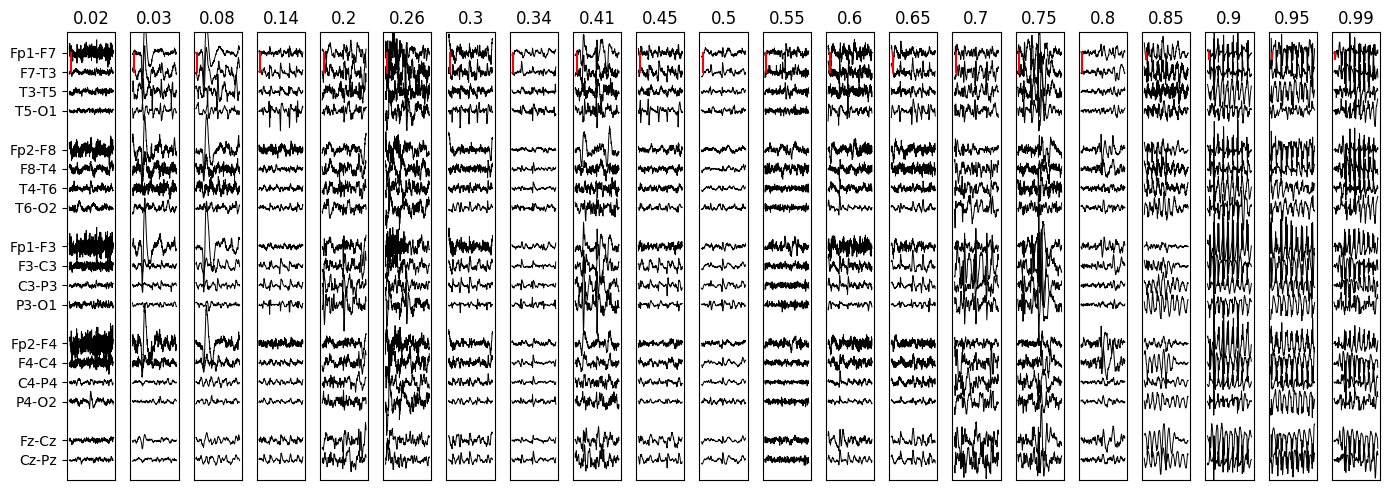

In [30]:
n = 20
x_start,x_end = 0,3
signal_start,signal_end = 6,9
scale = 100
path_pred = '/home/moritz/Desktop/programming/SpikeDeletion_clean/Models/gen_ref_rep/pred_Rep_two_referential.csv'
sample_type = 'positive'

# init info 
path_signals, titles, subtitles,Fq = init_info(sample_type,n=n,path_pred=path_pred)
# init figure
fig, axs = plt.subplots(1,n+1,figsize = (14,5))
# init montage and viewer


montage_module = init_montage_module(montages= [full_bipolar_montage])
viewer_modules = []
# create figure
for i in range(n+1):
    viewer_module = build_viewer_module(axs[i],montage_module,x_start=x_start,x_end=x_end,Fq=Fq)
    viewer_modules.append(viewer_module)
    if i > 16: scale = 300
    add_signal(path_signals[i],viewer_module,montage_module,signal_start,signal_end,Fq,scale)
    axs[i].plot((0.1,0.1),(0,-100/scale),'r')
    process_ticks_and_title(axs[i],i,titles[i])
fig.tight_layout()
fig.savefig(f'{sample_type}.png')